root uw20242025 medical
Database is ready!


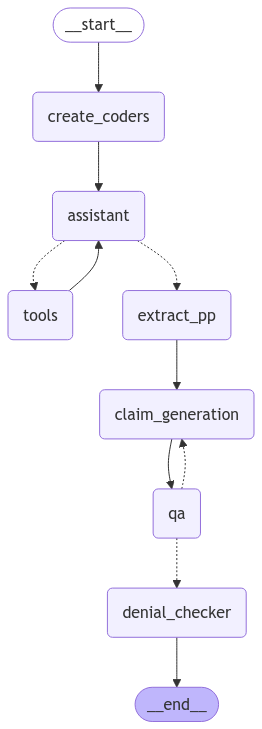

In [1]:
from components.classes import Coders, patient, insurance_company, patientgraph, Perspectives, pull_pi, ClaimOutput,comment_approve
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tracers.context import tracing_v2_enabled
import os
import json
from uuid import uuid4
from IPython.display import Image, display

unique_id = uuid4().hex[0:8]

from components.nodes import create_coders, assistant, extract_pp, claim_generation, route_graph, qa, route_review, denial_checker
from components.sql import tools

builder = StateGraph(patientgraph)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("LANGCHAIN_ENDPOINT")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("claim_generation", claim_generation)
builder.add_node("extract_pp",extract_pp)
builder.add_node("create_coders", create_coders)
builder.add_node("qa", qa)
builder.add_node("denial_checker", denial_checker)



# Define edges: these determine how the control flow moves
builder.add_edge(START, "create_coders")
builder.add_edge("create_coders", "assistant")
# builder.add_edge("assistant","claim_generation")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant1 is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant1 is a not a tool call -> tools_condition routes to END
    route_graph, ["tools","extract_pp" ]
)

builder.add_edge("tools", "assistant")
builder.add_edge("extract_pp", "claim_generation")

builder.add_edge("claim_generation", "qa")
builder.add_conditional_edges(
    "qa",
    # If the latest message (result) from assistant1 is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant1 is a not a tool call -> tools_condition routes to END
    route_review, ["denial_checker","claim_generation" ]
)
builder.add_edge("denial_checker", END)
react_graph = builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))
# with tracing_v2_enabled(project_name=os.getenv("LANGCHAIN_PROJECT")):
#     messages = [HumanMessage(content="Start process")]
#     messages = react_graph.invoke({"messages": messages, "medicalreport":'', "max_coders":3})

# print(messages)